# Image Matching Techniques


Image similarity methods can be used to build Image Retrieval systems where, given a query image, the goal is to find all similar images in a reference set. These systems can be used e.g. on a shopping website to suggest related products.

This notebook outlines a series of techniques to perform image matching, ranging from image processing approaches to the increasing complexity of SNN's.

For the majority of these approaches the image dimensions need to be fixed, indicating there needs to be consideration of how to handle different orientations and sizes.

## Technique 1 - SSIM

Peak Signal to noise ratio does not account for blurring of an image. The same image with 3 levels of blur will have the same PSNR. This along with MSE is a pixel by pixel comparison whereas SSIM is more robust, accounting for a combination of correlation loss, luminance distortion and contrast distortion

In [32]:
from skimage.metrics import structural_similarity as ssim
import imutils
import cv2
import matplotlib.pyplot as plt

In [30]:
imageA = cv2.imread('../../data/images/1.jpg')
imageB = cv2.imread('../../data/images/2.jpg')

grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)

grayA = cv2.resize(grayA, (100, 200)) 
grayB = cv2.resize(grayB, (100, 200)) 

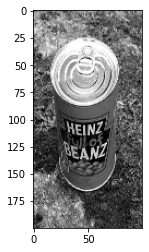

In [35]:
plt.imshow(grayA, cmap="gray")

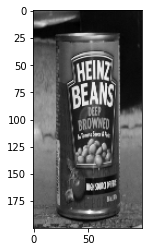

In [36]:
plt.imshow(grayB, cmap="gray")

In [31]:
(score, diff) = ssim(grayA, grayB, full=True)
diff = (diff * 255).astype("uint8")
print("SSIM: {}".format(score))

SSIM: 0.047410974281702795


SSIM has some drawbacks:

- It is a mathmatical process that does not involve any direct learning, meaning it will be rigid to scale, rotation and other typical augmentations that will be expected in real world images.
- While it uses regions of the image and structure, it is still limited to variations art the pixel level.
- Images must also have the same dimensions.
- You can see above that you have the same product but with a low SSIM score, this is not accounting for discovery issues like false postive rates which can come into play as well. This is where a trained ML approach shines - in cases where the environment is not controlled.

## Technique 2 - CNN Embeddings + Similarity Measure

The majority of state-of-the-art systems for image similarity use DNNs to compute a representation of an image (e.g. a vector of 512 floating point values). The similarity between two images is then defined as the cosine or the L2 distance between their respective DNN representation

This is what this section represents - DNN -> Feature Vector -> Normamlisation -> Distance Measure.

The DNN is typically fine tuned form a larger dataset on a given domain.

In [38]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import glob
import os.path

In [40]:
#################################################
# This function:
# Loads the JPEG image at the given path
# Decodes the JPEG image to a uint8 W X H X 3 tensor
# Resizes the image to 224 x 224 x 3 tensor
# Returns the pre processed image as 224 x 224 x 3 tensor
#################################################
def load_img(path):
 img = tf.io.read_file(path)
 img = tf.io.decode_jpeg(img, channels=3)
 img = tf.image.resize_with_pad(img, 224, 224)
 img = tf.image.convert_image_dtype(img,tf.float32)[tf.newaxis, ...]
 return img

In [50]:
#################################################
# This function:
# Loads the mobilenet model in TF.HUB
# Makes an inference for all images stored in a local folder
# Saves each of the feature vectors in a file
#################################################
def get_image_feature_vectors():
 
    module_handle = "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4"
    module = hub.load(module_handle)

    for filename in glob.glob('../../data/images/*.jpg'):

        print(filename)
        img = load_img(filename)
        features = module(img)
        feature_set = np.squeeze(features)

        outfile_name = os.path.basename(filename) + ".npz"
        out_path = os.path.join('C:/Users/jorda/Desktop/temp', outfile_name)

        np.savetxt(out_path, feature_set, delimiter=',')

get_image_feature_vectors()

../../data/images\1.jpg
../../data/images\2.jpg
../../data/images\3.jpg
../../data/images\4.jpg


The above using a MobileNet model, there may be better options to maintain resolution or have higher performing matching. Or a model trained on a more carefully chosen dataset and fine tuning on a domain dataset.

https://pypi.org/project/annoy/
https://towardsdatascience.com/image-similarity-detection-in-action-with-tensorflow-2-0-b8d9a78b2509

In [51]:
file_vector_1 = np.loadtxt('C:/Users/jorda/Desktop/temp/1.jpg.npz')
file_vector_2 = np.loadtxt('C:/Users/jorda/Desktop/temp/2.jpg.npz')
file_vector_3 = np.loadtxt('C:/Users/jorda/Desktop/temp/3.jpg.npz')
file_vector_4 = np.loadtxt('C:/Users/jorda/Desktop/temp/4.jpg.npz')

In [54]:
import scipy

print(scipy.spatial.distance.cosine(file_vector_1, file_vector_2))
print(scipy.spatial.distance.cosine(file_vector_1, file_vector_3))
print(scipy.spatial.distance.cosine(file_vector_1, file_vector_4))

0.3247678497901003
0.40632251755042614
0.48345567282401414


**We can see that the distance increases as the images become less alike** A threshold will need considered as well.

We could extend this to use ANNOY (or other neighbour, cluster approach)

Annoy (Approximate Nearest Neighbor Oh Yeah), is an open-sourced library for approximate nearest neighbor implementation.

https://towardsdatascience.com/image-similarity-detection-in-action-with-tensorflow-2-0-b8d9a78b2509


## Technique 3 - Micosoft/FastAI Approach.

- Fine Tuning
- 2019 SOTA Classification is a Strong Baseline for DeepMetric Learning

## Technique 3 - Siamese Neural Networks (1)

## Technique 4 - Siamese Neural Networks (2) - Triplet Learning

## Technique 5 - Facebook Faiss

## Resources

- https://medium.com/@datamonsters/a-quick-overview-of-methods-to-measure-the-similarity-between-images-f907166694ee
- https://www.pyimagesearch.com/2017/06/19/image-difference-with-opencv-and-python/
- https://www.pyimagesearch.com/2014/09/15/python-compare-two-images/
- https://github.com/microsoft/computervision-recipes/tree/master/scenarios/similarity
- https://towardsdatascience.com/image-similarity-detection-in-action-with-tensorflow-2-0-b8d9a78b2509